# QCoDeS example with Rigol DSG3136B

The [Rigol DSG3136B](https://www.rigol-uk.co.uk/product/rigol-dsg3136b-13-6ghz-rf-signal-generator/) is an RF signal generator.

## Setup and testing
### Setup
1. Make sure you have QCoDeS set up (see the [QCoDeS website](https://microsoft.github.io/Qcodes/index.html) or my notebook [14 minutes to QCoDeS](https://github.com/lairdgrouplancaster/14-minutes-to-QCoDeS/blob/main/14_minutes_to_QCoDeS.ipynb).)
2. Connect a USB cable to the instrument and turn it on.
3. On my PC, it seems to be necessary to run UltraSigma (Rigol's proprietary interface program), then unplug and replug USB.
4. Edit the code below to set your USB address, and run it.
   
Sometimes the final line throws the following error when the instrument should identify itself:

`pyvisa.errors.VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking '*IDN?' to <RigolDSG3136B: r_3136B_1>")`

If so, proceed to the next cell and check that the instrument correctly identifies itself there. If so, you don't have a problem.

In [1]:
import time
import qcodes as qc
from qcodes_contrib_drivers.drivers.Rigol.Rigol_DSG3136B import RigolDSG3136B

qc.Instrument.close_all() # Closes all open instruments, in case there is a duplicate for any reason.
sg_1 = RigolDSG3136B('r_3136B_1', 'USB0::0x1AB1::0x099C::DSG3E244600050::INSTR')  # Set your USB address here.

Connected to: Rigol Technologies DSG3136B (serial:DSG3E244600050, firmware:00.01.02) in 0.27s


### Test the connection
Run:

In [2]:
sg_1.identify()      # Should print the name of the instrument

'Rigol Technologies,DSG3136B,DSG3E244600050,00.01.02'

### Testing basic parameters
Run the following commands, and check by looking at the front of your instrument that they are having the desired effect.

In [3]:
sg_1.output('ON')       # Turn output on
sg_1.frequency(1.23e9)  # Set the instrument frequency
sg_1.level(-4.56)       # Set the instrument power level
sg_1.level()            # Query the instrument power level

-4.56

## Using the instrument in an experiment
This is how to use the instrument in a do1d() measurement scan.

### Setting up the experiment
Run the following commands to set up logging, the QCoDeS station, and the database:

In [4]:
import os

from qcodes.dataset import (
    do1d,
    initialise_or_create_database_at,
    load_or_create_experiment,
)

from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)

# Turn on logging:
qc.logger.start_all_logging()

# Set up the station with the instrument:
station = qc.Station()
station.add_component(sg_1)

# Set up a dummy DMM so that we can practise measuring later:
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)
station.add_component(dmm,dac)

# Set up the database:
db_file_path = os.path.join(os.getcwd(), 'Rigol_DSG3136B_demo_db.db')
initialise_or_create_database_at(db_file_path)
exp = load_or_create_experiment(experiment_name='Rigol_DSG3136B_demo_experiment', sample_name="no sample")

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lairde\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lairde\.qcodes\logs\240827-26880-qcodes.log


### Running a 1D scan
Run the code below. You should see the power level changing on the front of the instrument. At the end a graph of dummy data will appear below.

Starting experimental run with id: 16. Using 'qcodes.dataset.do1d'


  0%|          | 0/21 [00:00<?, ?it/s]

(results #16@C:\Users\lairde\OneDrive - Lancaster University\OneDrive Documents\Teaching\My classes\Python sandpit\DSG3136B documentation\Rigol_DSG3136B_demo_db.db
 ------------------------------------------------------------------------------------------------------------------------------------------------------------------
 r_3136B_1_level - numeric
 dmm_v1 - numeric,
 (<Axes: title={'center': 'Run #16, Experiment Rigol_DSG3136B_demo_experiment (no sample)'}, xlabel='Level (dBm)', ylabel='Gate v1 (V)'>,),
 (None,))

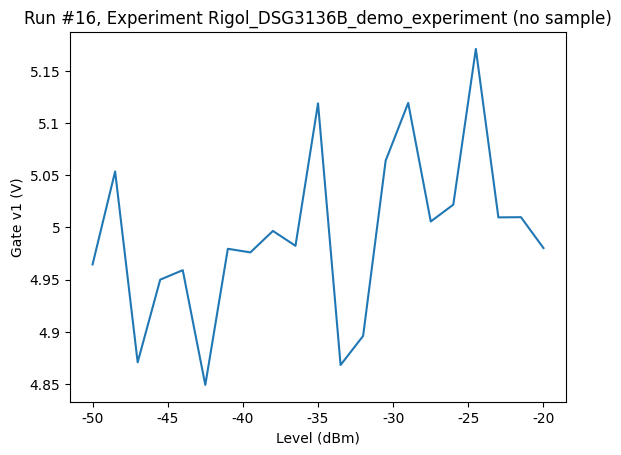

In [5]:
do1d(sg_1.level, -50, -20, 21, 0.1, dmm.v1, show_progress=True, do_plot=True)

## Using the instrument's sweep mode
Sweep mode is a faster way of stepping through a series of data points than setting frequency or power at every step. First you set up a list of sweep points, then you move through them in response to a trigger.
To set up a sweep (e.g. here, from 1 GHz to 2 GHz in 11 steps) do:

In [6]:
sg_1.sweep('FREQ')
sg_1.sweep_type('STEP')
sg_1.sweep_direction('FWD')
sg_1.sweep_shape('RAMP')
sg_1.sweep_frequency_start(1e9)
sg_1.sweep_frequency_stop(2e9)
sg_1.sweep_points(11)
sg_1.sweep_mode('SING')
sg_1.sweep_trigger('AUTO')
sg_1.point_trigger('BUS')

To run the sweep, do:

In [7]:
sg_1.sweep_execute() # To start the sweep.
sg_1.trigger()       # To step to the next point.
time.sleep(2)        
sg_1.trigger()       # And so on, with a delay if you want

To restart the sweep, do:

In [8]:
sg_1.sweep_reset()

To go back from sweep to continuous output, execute

In [9]:
sg_1.sweep('OFF')

It would probably be possible to incorporate all of this into the `doNd()` routines, but I haven't tried this.

## Closing the connection
After your work is complete, you can close the connection to the instrument with the following command.

In [10]:
sg_1.close()